In [1]:
import pandas as pd
import gower
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Load filtered rankings from Module 1
df_filtered = pd.read_csv('akc_breeds_filtered.csv')

# Load breed trait dataset – structure should contain columns like:
# Breed, Coat Length, Openness to Strangers, Energy Level, Barking Level, Shedding Level, Trainability, ...
traits = pd.read_csv('breed_traits.csv')

# Merge on breed name
df_cluster = pd.merge(df_filtered, traits, on='Breed', how='inner')

# ---------------------------
# 1. Prepare data
# ---------------------------

trait_cols = [
    'Coat Length',
    'Openness to Strangers', 'Energy Level', 'Shedding Level',
    'Trainability', 'Barking Level', 'Affection With Family', 'Adaptability Level'
]

X = df_cluster[trait_cols].copy()

# Convert categorical to object/string (Gower-friendly)
X['Coat Length'] = X['Coat Length'].astype(str)

# ---------------------------
# 2. Compute Gower distance matrix
# ---------------------------

gower_dist = gower.gower_matrix(X)

In [2]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Breed                       44 non-null     object 
 1   2013 Rank                   44 non-null     float64
 2   2014 Rank                   44 non-null     float64
 3   2015 Rank                   44 non-null     float64
 4   2016 Rank                   44 non-null     float64
 5   2017 Rank                   44 non-null     float64
 6   2018 Rank                   44 non-null     float64
 7   2019 Rank                   43 non-null     float64
 8   2020 Rank                   44 non-null     int64  
 9   links                       44 non-null     object 
 10  Image                       44 non-null     object 
 11  years_with_data             44 non-null     int64  
 12  net_change_2013_2020        44 non-null     float64
 13  avg_rank                    44 non-nu

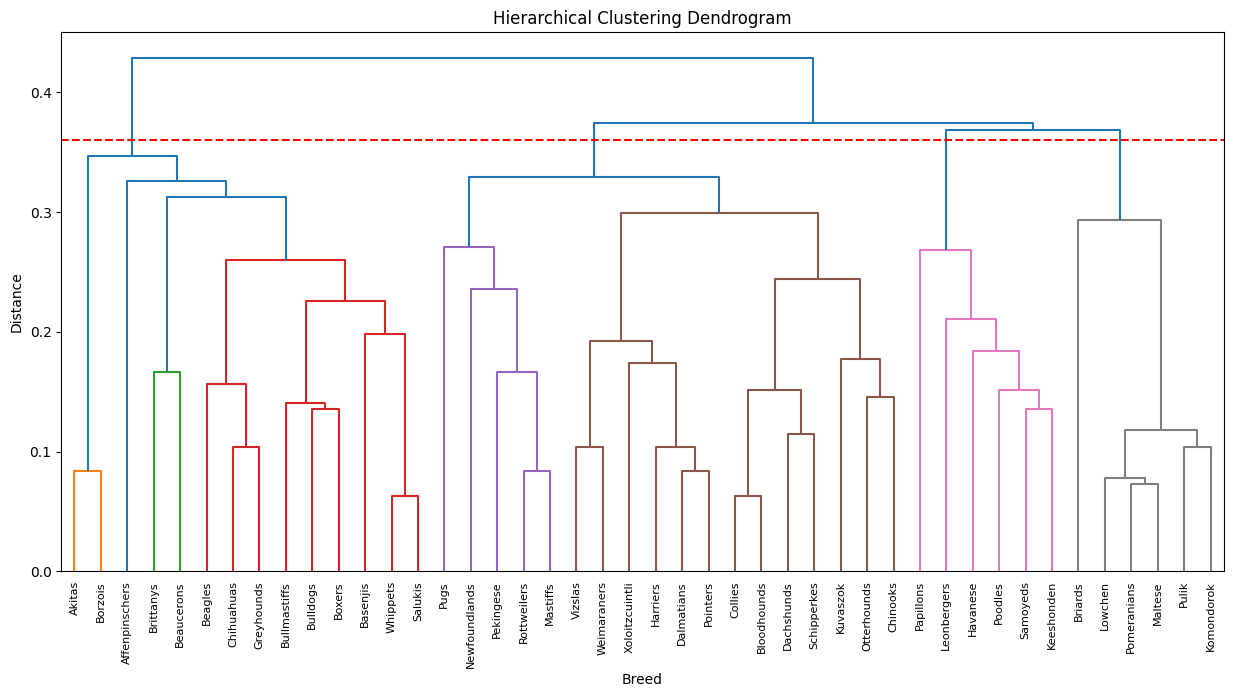

In [3]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Assuming df_cluster contains the 'Breed' column with breed names
breed_names = df_cluster['Breed'].values  # Extract breed names from the dataframe

# Convert the Gower distance matrix (which is square) into a condensed distance matrix
gower_dist_condensed = squareform(gower_dist)

# Compute the linkage matrix
Z = linkage(gower_dist_condensed, method='average')

# Plot the dendrogram
plt.figure(figsize=(15, 7))  # Optional: Adjust the figure size for better readability
dendrogram(Z, labels=breed_names)  # Pass breed names as labels

# Customize plot labels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Breed')
plt.ylabel('Distance')

# Add horizontal line
plt.axhline(y=0.36, color='r', linestyle='--', label='Cut at 0.36')

# Display the plot
plt.xticks(rotation=90)  # Rotate x-tick labels for better readability
plt.show()

In [4]:
from scipy.cluster.hierarchy import fcluster

# Generate cluster labels from the linkage matrix
k = 4   # For example, set the number of clusters
labels = fcluster(Z, t=k, criterion='maxclust')

df_cluster['Cluster'] = labels

In [5]:
from sklearn.preprocessing import LabelEncoder

X_umap = df_cluster[[
    'Coat Length',
    'Openness to Strangers', 'Energy Level', 'Shedding Level',
    'Trainability', 'Barking Level', 'Affection With Family', 'Adaptability Level'
]].copy()

# Encode Coat Length
le = LabelEncoder()
X_umap['Coat Length'] = le.fit_transform(X_umap['Coat Length'])

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_umap)

In [7]:
import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_embedded = umap_model.fit_transform(X_scaled)

df_cluster['UMAP1'] = X_embedded[:, 0]
df_cluster['UMAP2'] = X_embedded[:, 1]

/root/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-16 00:10:46.161656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765843846.181655     151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765843846.188674     151 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765843846.203794     151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17658

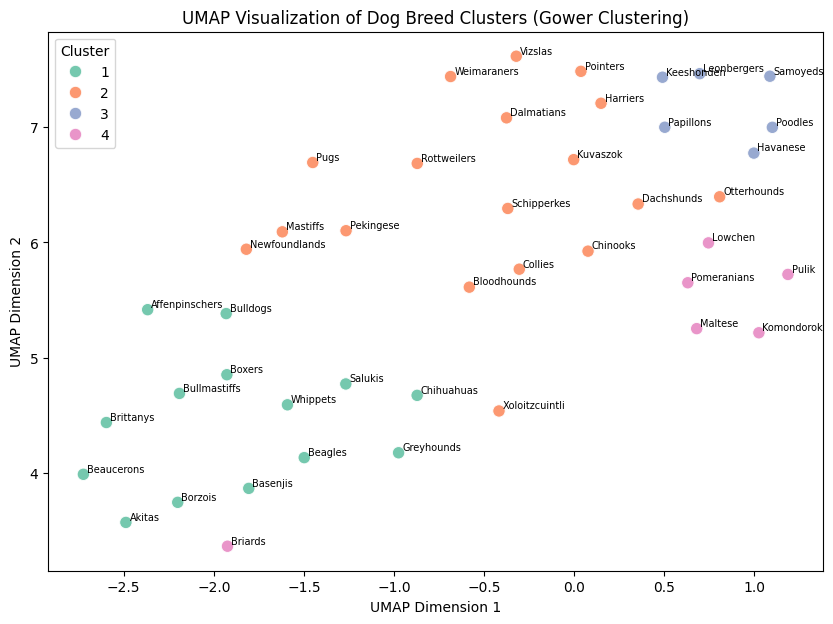

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df_cluster,
    x='UMAP1', y='UMAP2',
    hue='Cluster',
    palette='Set2',
    s=80,
    alpha=0.9
)

# Label points with breed names (optional)
for i, row in df_cluster.iterrows():
    plt.text(row['UMAP1']+0.02, row['UMAP2']+0.02, row['Breed'], fontsize=7)

plt.title("UMAP Visualization of Dog Breed Clusters (Gower Clustering)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [9]:
# Assuming df_cluster contains the 'Cluster' column that holds the cluster assignments
# and 'Breed' column contains the breed names.

# Group by cluster and print dog breeds for each cluster
for cluster_num, group in df_cluster.groupby('Cluster'):
    print(f"Cluster {cluster_num}:")
    print(group['Breed'].values)  # Print breed names in the current cluster
    print()  # For better readability

Cluster 1:
['Bulldogs' 'Beagles' 'Boxers' 'Brittanys' 'Chihuahuas' 'Akitas'
 'Bullmastiffs' 'Whippets' 'Basenjis' 'Borzois' 'Beaucerons' 'Greyhounds'
 'Salukis' 'Affenpinschers']

Cluster 2:
['Rottweilers' 'Dachshunds' 'Pugs' 'Mastiffs' 'Vizslas' 'Weimaraners'
 'Collies' 'Newfoundlands' 'Bloodhounds' 'Dalmatians' 'Pekingese'
 'Schipperkes' 'Pointers' 'Xoloitzcuintli' 'Otterhounds' 'Kuvaszok'
 'Chinooks' 'Harriers']

Cluster 3:
['Poodles' 'Havanese' 'Papillons' 'Samoyeds' 'Keeshonden' 'Leonbergers']

Cluster 4:
['Pomeranians' 'Maltese' 'Pulik' 'Briards' 'Lowchen' 'Komondorok']



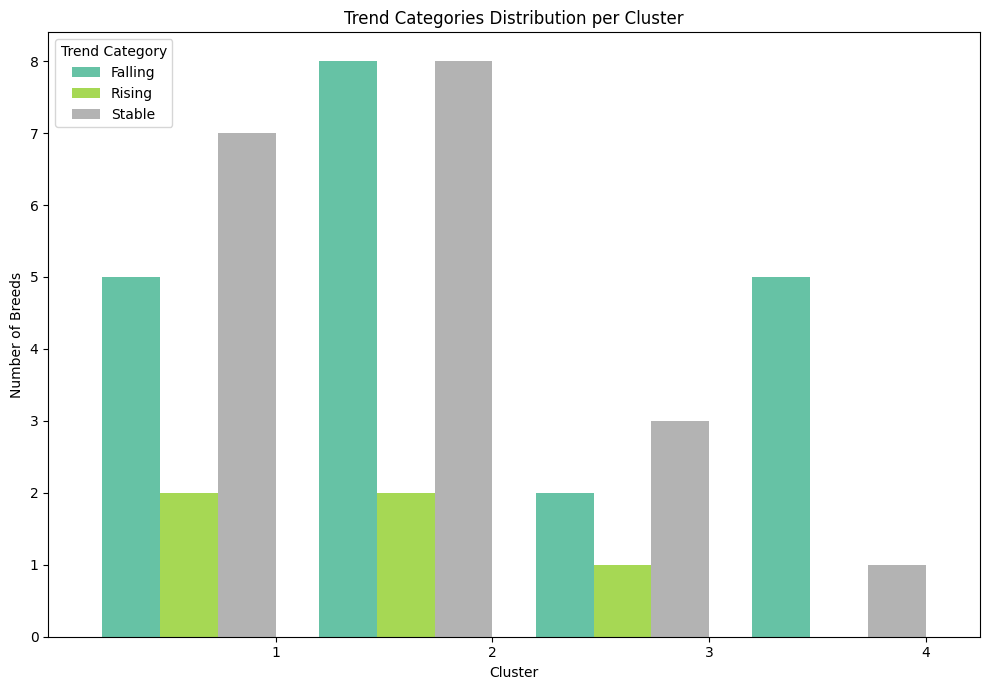

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_cluster contains the necessary columns:
# 'Cluster' - cluster assignments (from fcluster)
# 'trend_category' - trend labels (Rising, Falling, Stable)

# Group by cluster and trend category, and count occurrences
trend_counts = df_cluster.groupby(['Cluster', 'trend_category']).size().unstack(fill_value=0)

# Plotting the bar chart (side by side bars)
ax = trend_counts.plot(kind='bar', figsize=(10, 7), cmap='Set2', width=0.8, position=1)

# Customizing the plot
plt.title('Trend Categories Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Breeds')
plt.xticks(rotation=0)  # Keep x-ticks horizontal
plt.legend(title='Trend Category', loc='upper left')
plt.tight_layout()  # Adjust layout for better readability
plt.show()

In [11]:
from sklearn.metrics import silhouette_score

# gower_dist is your Gower distance matrix (square form)
# cluster_labels is the cluster assignment array, e.g. df_cluster['Cluster']

score = silhouette_score(
    gower_dist, 
    df_cluster['Cluster'], 
    metric='precomputed'
)

print(f"Average silhouette score (Gower): {score:.3f}")

Average silhouette score (Gower): 0.245


In [12]:
from sklearn.metrics import silhouette_samples
import numpy as np

sil_samples = silhouette_samples(gower_dist, df_cluster['Cluster'], metric='precomputed')
df_cluster['silhouette'] = sil_samples

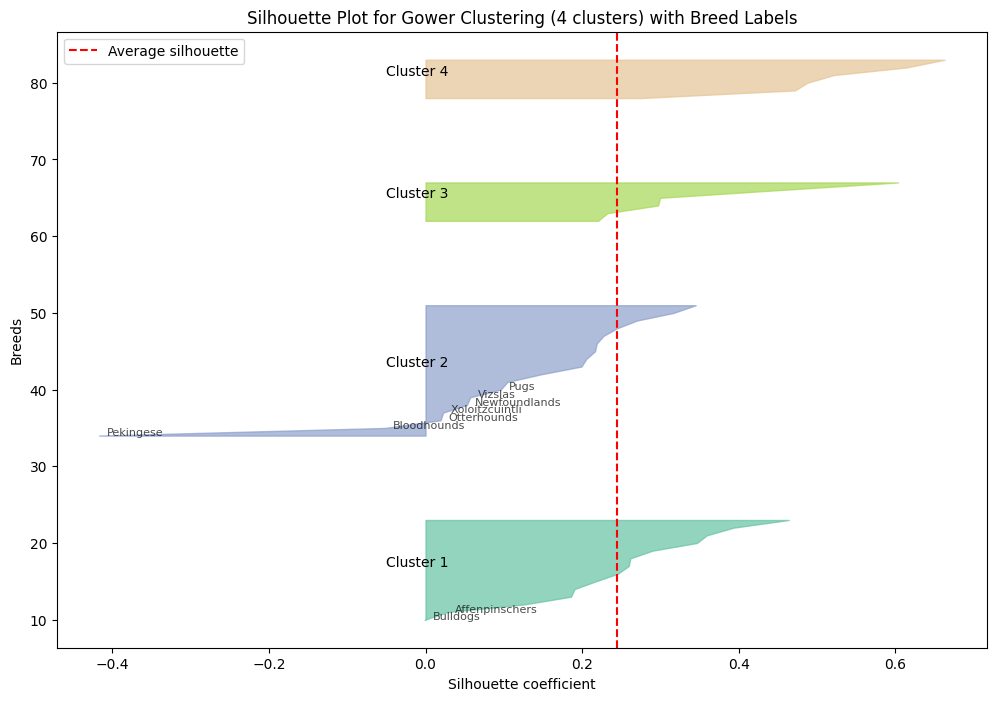

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

cluster_labels = df_cluster['Cluster'].unique()
n_clusters = len(cluster_labels)
silhouette_vals = df_cluster['silhouette'].values
breeds = df_cluster['Breed'].values
labels = df_cluster['Cluster'].values

y_lower = 10
plt.figure(figsize=(12, 8))

for i, cluster in enumerate(sorted(cluster_labels)):
    cluster_mask = (labels == cluster)
    cluster_silhouette_values = silhouette_vals[cluster_mask]
    cluster_breeds = breeds[cluster_mask]
    
    # Sort values for plotting
    sorted_indices = np.argsort(cluster_silhouette_values)
    cluster_silhouette_values = cluster_silhouette_values[sorted_indices]
    cluster_breeds = cluster_breeds[sorted_indices]
    
    size_cluster = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster
    
    color = cm.Set2(i / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster, f"Cluster {cluster}")
    
    # Annotate breeds with silhouette < 0.1
    for j, sil_val in enumerate(cluster_silhouette_values):
        if sil_val < 0.1:
            plt.text(sil_val + 0.01, y_lower + j, cluster_breeds[j], fontsize=8, alpha=0.7)
    
    y_lower = y_upper + 10

plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--", label="Average silhouette")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Breeds")
plt.title("Silhouette Plot for Gower Clustering (4 clusters) with Breed Labels")
plt.legend()
plt.show()

In [14]:
from scipy.stats import kruskal

pop_col = '2020 Rank'

groups = [
    df_cluster[df_cluster['Cluster'] == c][pop_col]
    for c in sorted(df_cluster['Cluster'].unique())
]

stat, p = kruskal(*groups)
print("Kruskal-Wallis p-value:", p)

Kruskal-Wallis p-value: 0.48637013631217096


/tmp/ipykernel_151/2617793110.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/root/venv/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/root/venv/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/root/venv/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead o

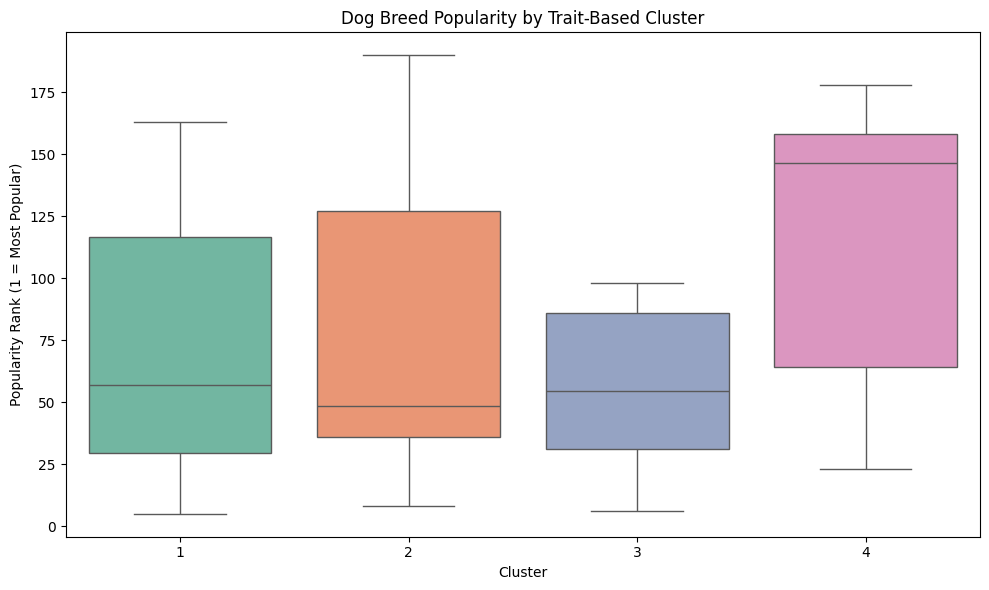

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_cluster,
    x='Cluster',
    y=pop_col,
    palette='Set2'
)

plt.title("Dog Breed Popularity by Trait-Based Cluster")
plt.xlabel("Cluster")
plt.ylabel("Popularity Rank (1 = Most Popular)")
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eb187a2d-bced-402d-86c5-d92317e22756' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>